<a href="https://colab.research.google.com/github/luisoliveirajr/CNN-DeepLearning-Folhas/blob/main/CNNPotato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Identificação de doença das folhas de tomates

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [18]:
#nessa célula faz a verificação se está usando o google colab ou não
#se estiver usando o google colab, monta o drive
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  from google.colab import drive
  #monta o drive do google drive
  drive.mount("/content/drive")

  import os
  #muda o diretório do google drive para o indicado abaixo
  os.chdir("/content/drive/My Drive/Colab Notebooks")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Constantes

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
#Carregar o Dataset. PlantVillage -- Milho

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Milho",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 531 files belonging to 2 classes.


In [ ]:
# mostrar o nomes das classes.

In [ ]:
class_names = dataset.class_names
class_names


['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___healthy']

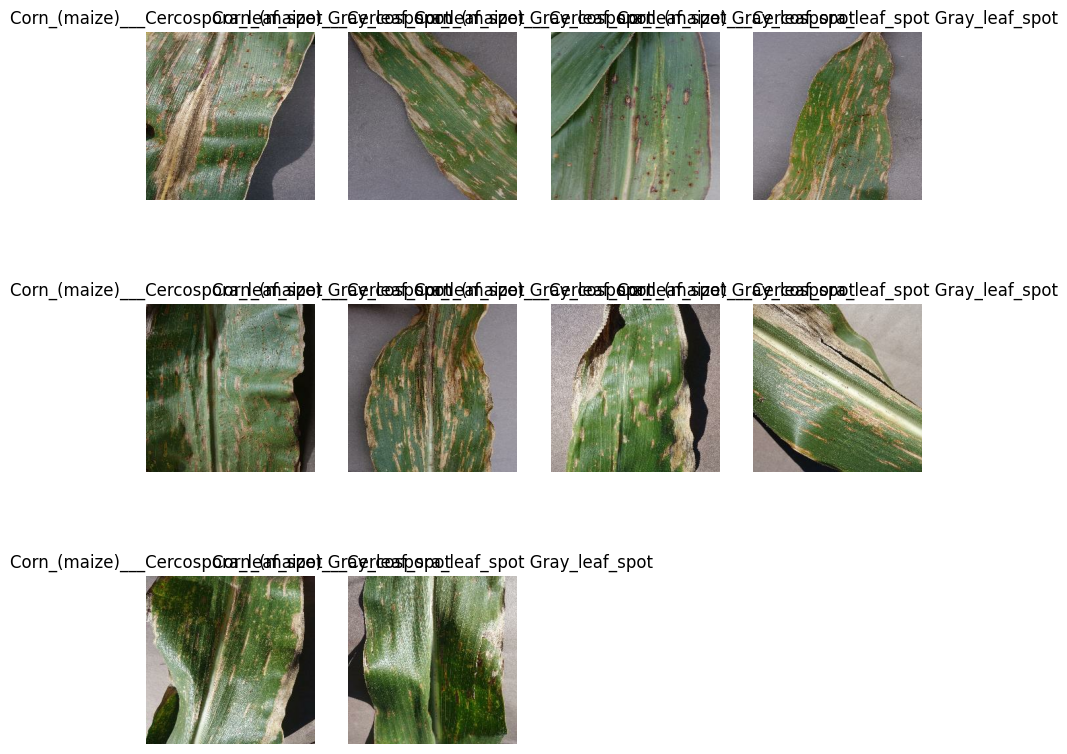

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
# 80% -> para treinamento.
# 20% -> 10% teste e 10% validação.

In [ ]:
# função para particionar o conjunto de dados
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)

    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds



In [ ]:
#Divisão do Dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print("Treinamento: "+str(BATCH_SIZE * len(train_ds)))
print("Validação: "+str(BATCH_SIZE * len(val_ds)))
print("Teste: "+str(BATCH_SIZE * len(test_ds)))

Treinamento: 14528
Validação: 1792
Teste: 1856


In [ ]:
# Otimização do carregamento do conjunto de dados usando o processador para carregar os lotes enquando a GPU está oculpada com processamento da rede.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
#Redimensior as imagens
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
#Data_augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
dimensoes = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

In [ ]:
#Definição do Modelo
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #Camada entrda
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = dimensoes),
    layers.MaxPooling2D((2, 2)),
    # Convolução - 01
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Convolução - 02
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Convolução - 03
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Convolução - 04
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Convolução - 05
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # -- Flatten
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = dimensoes)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
#Compliando o modelo
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
#treinando o modelo
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
